In [1]:
%reload_ext watermark
%watermark -a Jonathan.Ma -v -m -p numpy,scipy,pandas -g

Jonathan.Ma 

CPython 3.5.2
IPython 5.1.0

numpy 1.11.1
scipy 0.18.0
pandas 0.18.1

compiler   : GCC 4.2.1 Compatible Apple LLVM 4.2 (clang-425.0.28)
system     : Darwin
release    : 15.6.0
machine    : x86_64
processor  : i386
CPU cores  : 2
interpreter: 64bit
Git hash   :


* At what age will Connor McDavid’s points-per-game (points in hockey are assists + goals) most likely peak?
* What is the best estimate for Connor McDavid’s points-per-game in his peak season?
* What is the best estimate for Connor McDavid’s points-per-game in the 2027 season?
* Having completed that, what would be a different question that you’d like to interrogate this data towards? (Please just provide the angle / question you think might be interesting and potentially fruitful. You should not dive into the particular analysis you come up with. Just write up for us your thoughts on some interesting topic you’d pursue with the attached data.)

In [473]:
import csv
import pandas as pd
import numpy as np 

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import datetime as date
import scipy.stats.mstats as stats
from sklearn import linear_model

from sklearn.linear_model import Perceptron, LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cross_validation import train_test_split
from sklearn import  metrics, cross_validation, feature_selection, preprocessing
from sklearn.metrics import mean_squared_error

import statsmodels.formula.api as sm
from statsmodels.formula.api import ols
from statsmodels.tools.eval_measures import mse
from statsmodels.tools.tools import add_constant



In [420]:
DIR = '/Users/JMa/Learn/NHL/data'
df = pd.read_csv(DIR + '/raw/NHL_Forwards_v01.csv', parse_dates = ['DateOfBirth'])
df.head()

,PlayerId,Name,SeasonEnding,Team,GamesPlayed,GoalsPerGame,AssistsPerGame,TotalPointsPerGame,DateOfBirth
0,24,PAUL BROUSSEAU,2001,Florida Panthers,1,0.000000,0.000000,0.000000,1973-09-18
1,59,TONY MARTENSSON,2004,Mighty Ducks of Anaheim,6,0.166667,0.166667,0.333333,1980-06-23
2,75,NILS EKMAN,2000,Tampa Bay Lightning,28,0.071429,0.071429,0.142857,1976-03-11
3,75,NILS EKMAN,2001,Tampa Bay Lightning,43,0.209302,0.255814,0.465116,1976-03-11
4,75,NILS EKMAN,2004,San Jose Sharks,82,0.268293,0.402439,0.670732,1976-03-11


In [524]:
#prepare data & remove Connor McDavid to remove bias

# get age from birthdate add Age, Goals, Assists column
df['DateOfBirth'] = pd.to_datetime(df['DateOfBirth'], format='%m-%d-%y')    # 1
season = pd.to_datetime(df['SeasonEnding'], format='%Y')
df['DateOfBirth'] = df['DateOfBirth'].where(df['DateOfBirth'] < season, df['DateOfBirth'] -  np.timedelta64(100, 'Y'))   # 2
df['Age'] = (season - df['DateOfBirth']).astype('<m8[Y]') 
df['Goals'] = df['GoalsPerGame']*df['GamesPlayed']
df['Assists'] = df['AssistsPerGame']*df['GamesPlayed']

In [530]:
#remove outliers
df = df[df.TotalPointsPerGame < 60]
df = df[df.GamesPlayed < 100 ]
df = df[df.TotalPointsPerGame > 0]
df = df[df.Age < 45]
df.describe()

,PlayerId,SeasonEnding,GamesPlayed,GoalsPerGame,AssistsPerGame,TotalPointsPerGame,Age,Goals,Assists
count,8744.000000,8744.000000,8744.000000,8744.000000,8744.000000,8744.000000,8744.000000,8744.000000,8744.000000
mean,13346.096409,2008.120654,50.409652,0.177435,0.252330,0.429760,26.941903,10.021500,14.110247
std,15431.151969,4.994767,26.185943,0.133066,0.180526,0.273447,4.569071,9.667052,13.525588
min,59.000000,2000.000000,1.000000,0.000000,0.000000,0.017857,18.000000,0.000000,0.000000
25%,8631.000000,2003.000000,26.000000,0.079365,0.116667,0.214286,23.000000,2.000000,3.000000
50%,9036.000000,2008.000000,56.500000,0.153846,0.216216,0.377913,26.000000,7.000000,10.000000
75%,11417.000000,2012.000000,75.000000,0.250000,0.350649,0.597561,30.000000,15.000000,21.000000
max,231299.000000,2016.000000,82.000000,1.000000,1.444444,2.000000,43.000000,65.000000,92.000000


1. Average Player played 50.4 games.
2. Average Age is 35.5
3. Most Goals Per Game is 1.0
4. Most Assists Per Game is 1.4
5. Most Total Points Per Game is 2.0

In [531]:
df.corr()

,PlayerId,SeasonEnding,GamesPlayed,GoalsPerGame,AssistsPerGame,TotalPointsPerGame,Age,Goals,Assists
PlayerId,1.000000,0.101097,-0.132945,-0.113798,-0.124946,-0.137834,-0.134020,-0.150772,-0.160654
SeasonEnding,0.101097,1.000000,-0.018017,-0.013430,-0.037095,-0.030984,-0.030972,-0.024836,-0.035675
GamesPlayed,-0.132945,-0.018017,1.000000,0.309147,0.294148,0.344526,0.154795,0.693702,0.690177
GoalsPerGame,-0.113798,-0.013430,0.309147,1.000000,0.509920,0.823198,0.032320,0.783831,0.585442
AssistsPerGame,-0.124946,-0.037095,0.294148,0.509920,1.000000,0.908123,0.109547,0.589394,0.796763
TotalPointsPerGame,-0.137834,-0.030984,0.344526,0.823198,0.908123,1.000000,0.088032,0.770474,0.810695
Age,-0.134020,-0.030972,0.154795,0.032320,0.109547,0.088032,1.000000,0.079425,0.131134
Goals,-0.150772,-0.024836,0.693702,0.783831,0.589394,0.770474,0.079425,1.000000,0.830286
Assists,-0.160654,-0.035675,0.690177,0.585442,0.796763,0.810695,0.131134,0.830286,1.000000


1. High Correlation Between Total Points Per Game (TPPG) and Assists and Goals Per Game, which is expected. 
2. Assists has a greater impact to TPPG than goals, since up to 3 An assist is awarded to the player or players (maximum of two) who touch the puck prior to the goal, provided no defender plays or possesses the puck in between.
3. Some Correlation between TPPG and Age and Games Played, though not highly correlated. 

In [532]:
#check for normal distribution of independent variables
#Dependent Variable = TPPG
#Independent Variables = Goals Per Game, Assist Per Game, Age, Games Played
#normaltest
GPG, GPGpval = stats.normaltest(df.GoalsPerGame)
APG, APGpval = stats.normaltest(df.AssistsPerGame)
GAge, Agepval = stats.normaltest(df.Age)

#make sure p vals are below 0.05 #0, 0, 4.13e-55
assert GPGpval < 0.05 
assert  APGpval < 0.05 
assert Agepval < 0.05

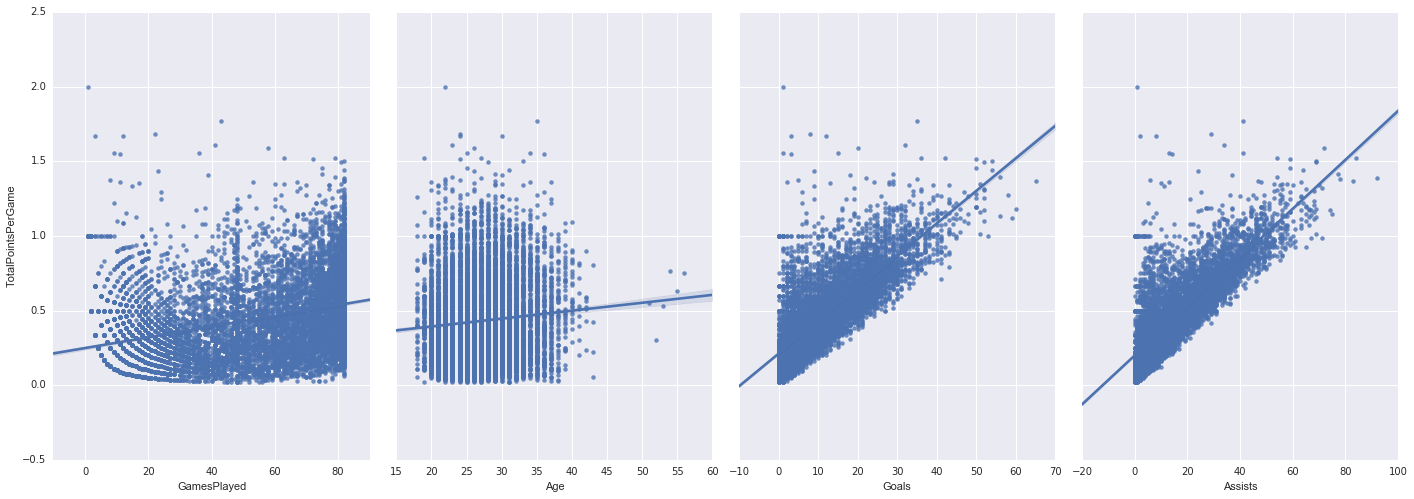

In [528]:
# Visualize distributions
sns.pairplot(df, x_vars=['GamesPlayed','Age','Goals', 'Assists'], y_vars='TotalPointsPerGame', size=7, aspect=0.7, kind='reg')

In [529]:
df_01 = df[df.SeasonEnding == 2001]
df_02 = df[df.SeasonEnding == 2002]
df_03 = df[df.SeasonEnding == 2003]
df_04 = df[df.SeasonEnding == 2004]
df_05 = df[df.SeasonEnding == 2005]
df_06 = df[df.SeasonEnding == 2006]
df_07 = df[df.SeasonEnding == 2007]
df_08 = df[df.SeasonEnding == 2008]
df_09 = df[df.SeasonEnding == 2009]
df_10 = df[df.SeasonEnding == 2010]
df_11 = df[df.SeasonEnding == 2011]
df_12 = df[df.SeasonEnding == 2012]
df_13 = df[df.SeasonEnding == 2013]
df_14 = df[df.SeasonEnding == 2014]
df_15 = df[df.SeasonEnding == 2015]
df_16 = df[df.SeasonEnding == 2016]

In [522]:
# load data into array structure
X = df[['Age', 'GamesPlayed', 'Goals', 'Assists','TotalPointsPerGame']].values.copy()
# split 80/20
X_train, X_valid, y_train, y_valid = cross_validation.train_test_split(X[:, :-1], X[:,-1], train_size =0.80)
# Ordinary Least Squares Regression model
model = sm.OLS(y_train, add_constant(X_train)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.871
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     729.0
Date:                Mon, 29 Aug 2016   Prob (F-statistic):          2.73e-190
Time:                        11:12:00   Log-Likelihood:                 370.57
No. Observations:                 436   AIC:                            -731.1
Df Residuals:                     431   BIC:                            -710.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.2518      0.050      5.031      0.000         0.153     0.350
x1             0.0023      0.001      1.955      0.051     -1.24e-05     0.005
x2            -0.0055      0.000    -20.048      0.000        -0.006    -0.005
x3             0.0142      0.001     15.577      0.000         0.012     0.016
x4             0.0151      0.001     21.461      0.000         0.014     0.016
==============================================================================
Omnibus:                      191.415   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1320.756
Skew:                           1.745   Prob(JB):                    1.59e-287
Kurtosis:                      10.780   Cond. No.                         744.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [523]:
ypred = model.predict(add_constant(X_valid))
print(mse(ypred,y_valid))

0.0105962149437


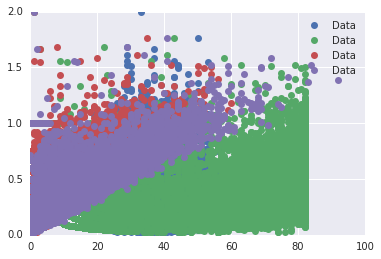

In [515]:
fig, ax = plt.subplots()
ax.plot(X_train, y_train, 'o', label="Data")
#ax.plot(X_valid, y_valid, 'b-', label="True")
#ax.plot(np.hstack((X_train, X_valid)), ypred, 'r', label="OLS prediction")
ax.legend(loc="best");

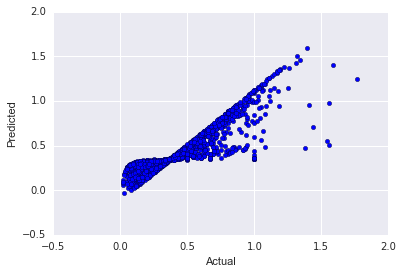

In [490]:
fig, ax = plt.subplots(1,1)
ax.scatter(y_valid, ypred)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
plt.show()

In [510]:
lm = LinearRegression()
lm.fit(X_train, y_train)
print('Intercept is %f' % lm.intercept_)
cross_validation.cross_val_score(lm, X_train,y_train, scoring='r2')
ypred = lm.predict(X_valid)
mean_squared_error(ypred, y_valid)

Intercept is 0.316691


0.013728956289447156

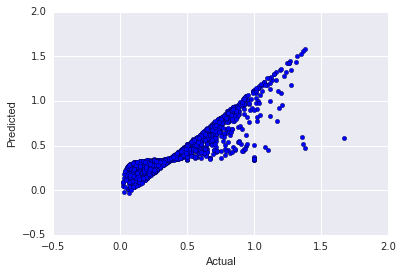

In [511]:
fig, ax = plt.subplots(1,1)
ax.scatter(y_valid, ypred)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
plt.show()

In [518]:
tppg_model = ols("TotalPointsPerGame ~ np.log(Age) + Goals + Assists", data=df).fit()
tppg_model.summary()
tppg_model.pvalues


Intercept       1.015215e-13
np.log(Age)     2.322752e-01
Goals          1.827943e-178
Assists         0.000000e+00
dtype: float64

In [459]:
# create X and y
feature_cols = ['Age']
X = data[feature_cols]
y = data.TotalPointsPerGame

# instantiate and fit
tppg_model = linear_model.LinearRegression()
tppg_model.fit(X, y)

# print the coefficients
print( tppg_model.intercept_)
print (tppg_model.coef_)
print(list(zip(feature_cols, tppg_model.coef_)))

### STATSMODELS ###
# predict for a new observation
print(tppg_model.predict(11))


0.319247374468
[ 0.00311306]
[('Age', 0.0031130648435165318)]
[ 0.35349109]


In [468]:
# create X and y
X = data[['Age', 'GamesPlayed', 'GoalsPerGame', 'AssistsPerGame']]
y = data.TotalPointsPerGame
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
lm2 = LinearRegression()
lm2.fit(X_train, y_train)
y_pred = lm2.predict(X_test)
print (np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

0.00314410012466


In [ ]:
X = PolynomialFeatures(interaction_only=True).fit_transform(X_data)
model = Perceptron(fit_intercept=False, n_iter=10, shuffle=False).fit(X, y_data)

In [386]:
def linreg(data):
    #Multivariate Linear Regression
    #normalize
    data = (data - data.mean())/ data.std()

    # Features X (GPPG, APPG, Age, Games Played) and Response Variables y (TPPG)
    colnum = data.shape[1]
    X_data = data.iloc[:,0:colnum-1].as_matrix()
    y_data = data.iloc[:, colnum-1:colnum].as_matrix()

    #create linear regression model
    model = LinearRegression()  
    model.fit(X_data, y_data) 

    # The coefficients
    print('Coefficients: \n', model.coef_)
    # The mean square error
    print("Residual sum of squares: %.2f"
          % np.mean((model.predict(X_data) - y_data) ** 2))
    # Explained variance score: 1 is perfect prediction
    print('R^2: %.2f' % model.score(X_data,y_data))
    return model

In [384]:
df_GPG = df[['GoalsPerGame', 'TotalPointsPerGame']]
df_APG = df[['AssistsPerGame', 'TotalPointsPerGame']]
df_Age = df[['Age', 'TotalPointsPerGame']]
df_GP = df[['GamesPlayed', 'TotalPointsPerGame']]
df_GAPG = df[['GoalsPerGame', 'AssistsPerGame', 'TotalPointsPerGame']]
df_GAPG_Age = df[['Age','GoalsPerGame', 'AssistsPerGame', 'TotalPointsPerGame']]
df_All = df[['GamesPlayed', 'Age','GoalsPerGame', 'AssistsPerGame', 'TotalPointsPerGame']]

In [387]:
Samples =[df_GPG, df_APG,df_Age, df_GP, df_GAPG, df_GAPG_Age, df_All]
list(map(linreg, Samples))

Coefficients: 
 [[ 0.82314865]]
Residual sum of squares: 0.32
R^2: 0.68
Coefficients: 
 [[ 0.90814687]]
Residual sum of squares: 0.18
R^2: 0.82
Coefficients: 
 [[ 0.07830999]]
Residual sum of squares: 0.99
R^2: 0.01
Coefficients: 
 [[ 0.34467215]]
Residual sum of squares: 0.88
R^2: 0.12
Coefficients: 
 [[ 0.48660291  0.66003108]]
Residual sum of squares: 0.00
R^2: 1.00
Coefficients: 
 [[ -1.30464123e-05   4.86602539e-01   6.60032541e-01]]
Residual sum of squares: 0.00
R^2: 1.00
Coefficients: 
 [[ -5.96831533e-05  -7.65390588e-06   4.86615517e-01   6.60042968e-01]]
Residual sum of squares: 0.00
R^2: 1.00


[LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)]

In [ ]:
Conner McDavid. 2015-16	Edmonton Oilers

In [ ]:
GP	G	A	Pts	PIM
45	16	32	48	18